# Trajectory Tracking with Integral Loss

In [3]:
from torchdyn.core import NeuralODE
from torchdyn.nn import *
from torchdyn.datasets import *
from torchdyn.utils import *

%load_ext autoreload
%autoreload 2

## Integral Loss

We consider a loss of type

$$
    \ell_\theta := \int_0^S g(z(t))d\tau
$$

where $z(s)$ satisfies the neural ODE initial value problem 

$$
    \left\{
    \begin{aligned}
        \dot{z}(t) &= f(z(t), \theta(t))\\
        z(0) &= x
    \end{aligned}
    \right. \quad t\in[0,T]
$$

where $\theta(t)$ is parametrized with some spectral method (`Galerkin-style`),  i.e. $\theta(t)=\theta(t,\omega)$ [$\omega$: parameters of $\theta(t)$].

**REMARK:** In `torchdyn`, we do not need to evaluate the following integral in the forward pass of the ODE integration.
In fact, we will compute the gradient $d\ell/d\omega$ just by solving backward 

$$
    \begin{aligned}
        \dot\lambda (t) &= -\frac{\partial f}{\partial z}\lambda(t) + \frac{\partial g}{\partial z} \\
        \dot\mu (t) &= -\frac{\partial f}{\partial \theta}\frac{\partial \theta}{\partial \omega}\lambda(t)
    \end{aligned}~~\text{with}~~
    \begin{aligned}
        \lambda (T) &= 0\\
        \mu (T) &= 0
    \end{aligned}
$$

and, $\frac{d\ell}{d\omega} = \mu(0)$. Check out [this paper](https://arxiv.org/abs/2003.08063) for more details on the integral adjoint for Neural ODEs.

**Example:** Use a neural ODE to track a 2D curve $\gamma:[0,\infty]\rightarrow \mathbb{S}_2$ ($\mathbb{S}_2$: unit circle, $\mathbb{S}_2:=\{x\in\mathbb{R}^2:||x||_2=1\}$), i.e.

$$
    \gamma(s) := [\cos(2\pi s), \sin(2\pi s)]
$$

which has periodicity equal to $1$: $\forall n\in\mathbb{N}, \forall s\in[0,\infty]~~\gamma(s) = \gamma(ns)$.

Let suppose to train the neural ODE for $s\in[0,1]$. Therefore we can easily setup the integral cost as

$$
    \ell_\theta := \int_0^1 (h(\tau)-\gamma(\tau))^2 d\tau
$$

In [31]:
# simple Callables are also fine as integral losses, as long as they're callable with `t, x`. We use nn.Modules for convenience, since
# we compute the reference signal here as well

class SineReferenceIntegralLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def y(self, t):
        return torch.tensor([torch.cos(2*np.pi*t), torch.sin(2*np.pi*t)])[None, :].to(t)
        
    def forward(self, t, x):
        int_loss = ((self.y(t)-x)**2).sum(1, keepdim=True)
        return int_loss

**Note:** In this case we do not define any dataset of initial conditions and load it into the dataloader. Instead, at each step, we will sample new ICs from a normal distrubution centered in $\gamma(0) = [1,0]$

$$
    x_t \sim \mathcal{N}(\gamma(0),0.1)
$$

However, we still define a "dummy" `trainloader` to use `pythorch_lightning`'s API.

In [60]:
# dummy trainloader
train = torch.utils.data.TensorDataset(torch.zeros(1), torch.zeros(1))
trainloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
t_span = torch.linspace(0, 2, 60)

**Learner**

In [61]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iterations = 0
        
    def forward(self, x):
        return self.model(x)    
    
    def training_step(self, batch, batch_idx):    
        self.iterations += 1
        # We sample from Normal distribution around "nominal" initial condition
        x = torch.tensor([1.,0.])
        x = (x + 0.5*torch.randn(4096, 2)).to(device)
        _, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1]
        
        # We need to evaluate a "dummy loss" (just the summed output of the model)
        # to construct the graph for the 'backward()' "triggering" integral adjoint computation 
        loss = 0.*y_hat.sum()
        intloss = None
        
        if self.iterations % 10 == 0:
            with torch.no_grad():
            # compute integral loss explicitly by augmentation of state with 
            # an aux. variable. See `Dissecting Neural ODEs` for more information
                model.sensitivity = model.vf.sensitivity = 'autograd'  
                x = torch.cat([torch.zeros(x.shape[0], 1).to(x), x], 1)
                _, sol = self.model(x, t_span)
                intloss = sol[-1, :, :1].mean()
                model.sensitivity = model.vf.sensitivity = 'interpolated_adjoint'
            self.log('intloss', intloss, prog_bar=True)

        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=3e-3)

    def train_dataloader(self):
        return trainloader

## Parameter Varying Neural ODE

**Model**

In [63]:
# We use a Galerkin Neural ODE with one hidden layer, 
# Fourier spectrum (period=1) and only 2 freq.s
f = nn.Sequential(nn.Linear(2, 64),
                  nn.Tanh(),
                  nn.Linear(64, 2)).to(device)

# Define the model
model = NeuralODE(f, 
                 solver='rk4',
                 sensitivity='interpolated_adjoint',
                 solver_adjoint='dopri5',
                 atol_adjoint=1e-5,
                 rtol_adjoint=1e-5,
                 integral_loss=SineReferenceIntegralLoss()).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [ ]:
# Train the model (will take a while)
learn = Learner(model)
trainer = pl.Trainer(max_epochs=1000, gpus=1)
trainer.fit(learn)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 322   
------------------------------------
322       Trainable params
0         Non-trainable params
322       Total params
0.001     Total estimated model params size (MB)
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

**Plots**

We first evaluate the model on a test set of initial conditions sampled from $\mathcal{N}(\gamma(0),\sigma\mathbb{I})$. Since we trained the neural ODE with $\sigma=0.1$, now we test it with $\sigma=0.2$.

In [57]:
t_span = torch.linspace(0, 12, 460).to(device)
x_test = torch.tensor([1.,0.])
x_test = (x_test + 0.2*torch.randn(100, 2)).to(device)
model = model.to(device)
_, trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()

**Depth evolution of the system** -> The system is trained for $s\in[0,1]$ and then we extrapolate until $s=5$

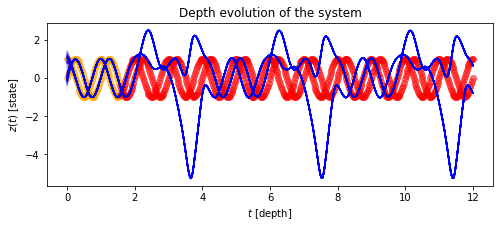

In [58]:
K = 60
t_span = t_span.cpu()
y1 = np.cos(2*np.pi*t_span)
y2 = np.sin(2*np.pi*t_span)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.scatter(t_span[:K], y1[:K], color='orange',alpha=0.5)
ax.scatter(t_span[:K], y2[:K], color='orange',alpha=0.5)
ax.scatter(t_span[K:], y1[K:], color='red',alpha=0.5)
ax.scatter(t_span[K:], y2[K:], color='red',alpha=0.5)
for i in range(len(x_test)):
    ax.plot(t_span, trajectory[:,i,:], color='blue', alpha=.1)
ax.set_xlabel(r"$t$ [depth]")
ax.set_ylabel(r"$z(t)$ [state]")
ax.set_title(r"Depth evolution of the system");

**State-space trajectories**
-> All the (random) IC converge to the desired trajectory

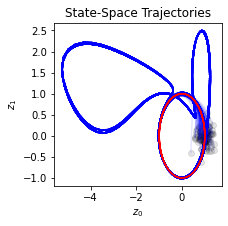

In [59]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(x_test)):
    ax.plot(trajectory[:,i,0], trajectory[:,i,1], color='blue', alpha=.1)
    ax.scatter(trajectory[0,i,0], trajectory[0,i,1], color='black', alpha=.1)
ax.plot(y1[:100],y2[:100], color='red')
ax.set_xlabel(r"$z_0$")
ax.set_ylabel(r"$z_1$")
ax.set_title(r"State-Space Trajectories");